### Charger les données :

In [9]:
pip uninstall arff

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install liac-arff

Note: you may need to restart the kernel to use updated packages.


In [81]:
# 1. Chargement des bibliothèques
import arff
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, cv

### Exploration des données

In [17]:
# Chargement du fichier ARFF
with open("freMTPL2freq.arff", "r") as f:
    dataset = arff.load(f)

# Conversion en DataFrame
data = dataset['data']
columns = [attr[0] for attr in dataset['attributes']]
df = pd.DataFrame(data, columns=columns)

In [19]:
# Configuration des graphes
sns.set(style="whitegrid")
%matplotlib inline

In [20]:
# Aperçu général des données
df.shape  # (678013, 12)
df.dtypes
df.describe()
df['ClaimNb'].value_counts().sort_index()

ClaimNb
0.0     643953
1.0      32178
2.0       1784
3.0         82
4.0          7
5.0          2
6.0          1
8.0          1
9.0          1
11.0         3
16.0         1
Name: count, dtype: int64

In [22]:
# Vérification des valeurs manquantes (tu as dit qu'il n'y en a pas, on confirme)
df.isnull().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

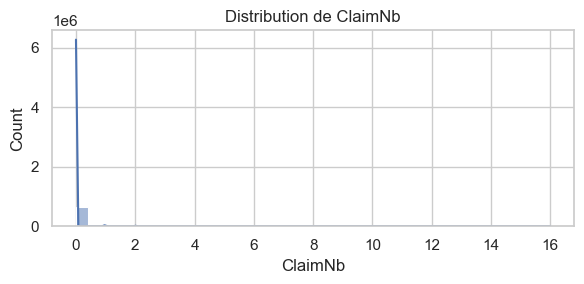

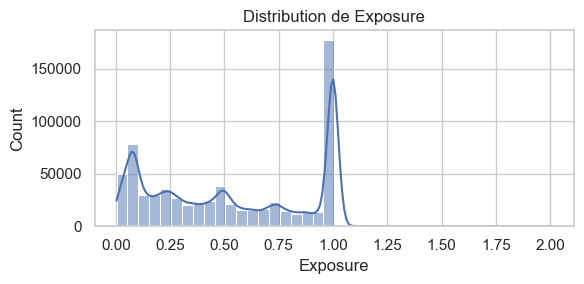

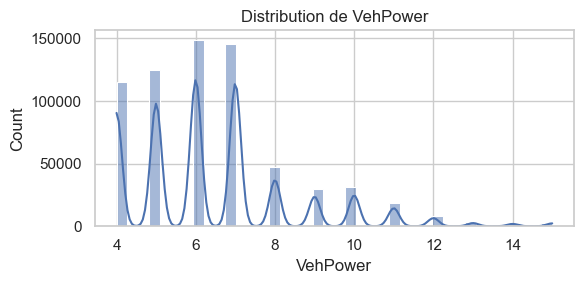

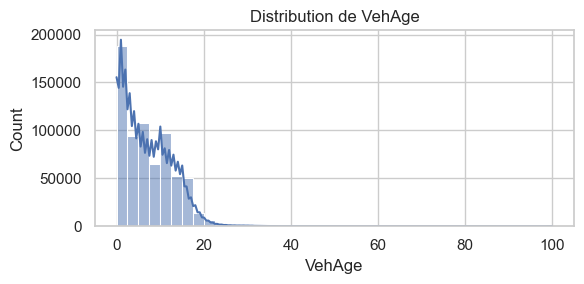

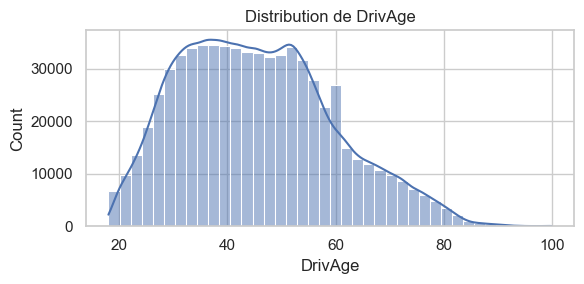

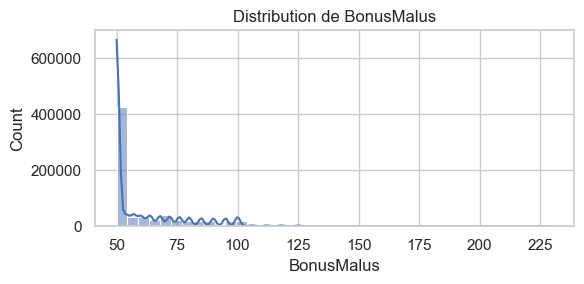

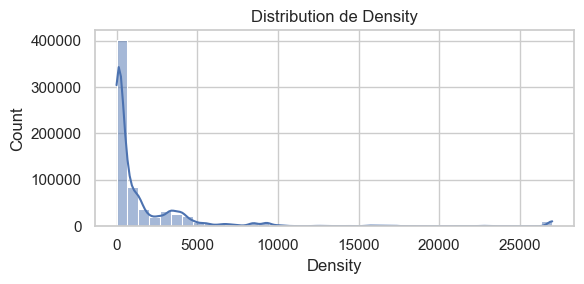

In [28]:
# 4. Variables numériques – distribution
num_vars = ['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

for var in num_vars:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[var], kde=True, bins=40)
    plt.title(f"Distribution de {var}")
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

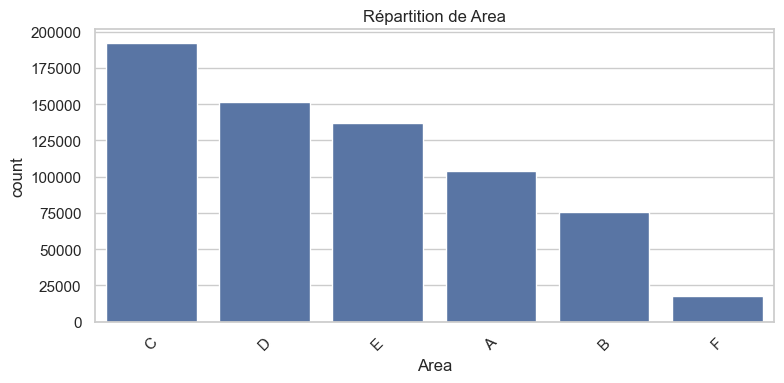

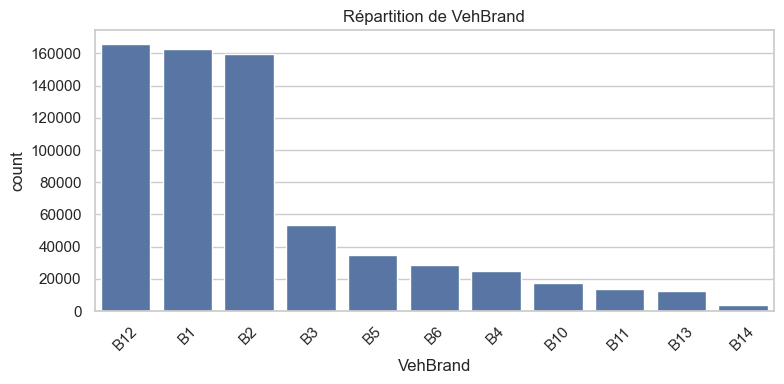

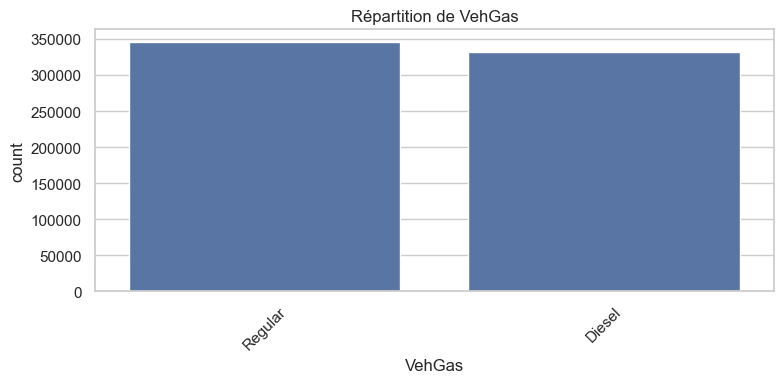

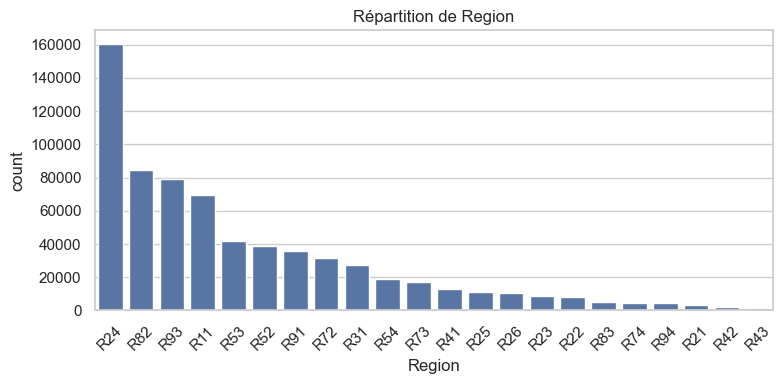

In [30]:
# 5. Variables catégorielles – répartition
cat_vars = ['Area', 'VehBrand', 'VehGas', 'Region']

for var in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=var, order=df[var].value_counts().index)
    plt.title(f"Répartition de {var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

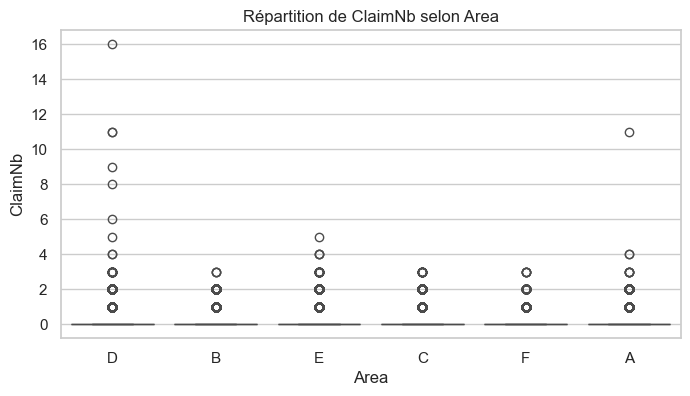

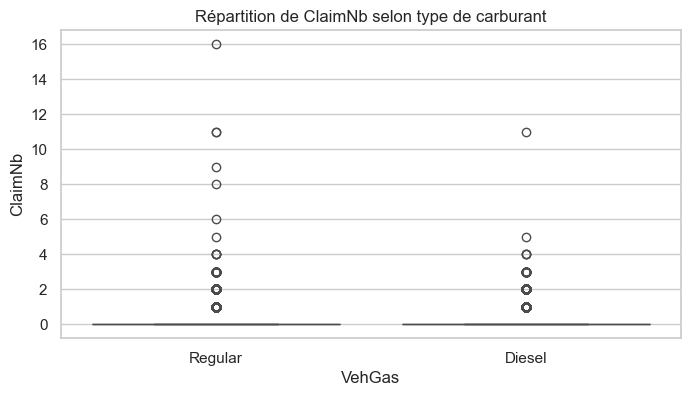

In [32]:
# 6. Boxplots : fréquence des sinistres par catégorie
plt.figure(figsize=(8, 4))
sns.boxplot(x='Area', y='ClaimNb', data=df)
plt.title("Répartition de ClaimNb selon Area")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='VehGas', y='ClaimNb', data=df)
plt.title("Répartition de ClaimNb selon type de carburant")
plt.show()

### Modele GLM

In [34]:
# Cast des variables string en category
cat_vars = ['Area', 'VehBrand', 'VehGas', 'Region']
for col in cat_vars:
    df[col] = df[col].astype('category')

# Supprimer les lignes avec Exposure = 0
df = df[df["Exposure"] > 0]

# GLM avec offset log(Exposure)
model = smf.glm(
    formula="ClaimNb ~ Area + VehPower + VehAge + DrivAge + BonusMalus + VehBrand + VehGas + Density + Region",
    data=df,
    family=sm.families.Poisson(),
    offset=np.log(df["Exposure"])
).fit()

# Résumé
print(model.summary())

# Évaluation
pred = model.predict()
rmse = np.sqrt(np.mean((df["ClaimNb"] - pred) ** 2))
print(f"\nRMSE : {rmse:.4f}")
print(f"Deviance : {model.deviance:.2f}")
print(f"AIC : {model.aic:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677970
Model Family:                 Poisson   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4331e+05
Date:                Sat, 17 May 2025   Deviance:                   2.1729e+05
Time:                        20:34:49   Pearson chi2:                 1.79e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01054
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.9591      0.04

#### Validation croisée

In [100]:
# Pipeline
glm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', PoissonRegressor(alpha=1e-12, max_iter=1000))  # alpha très bas pour coller au GLM classique
])

# Validation croisée : ici sur 5 plis
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# RMSE = racine de l’erreur quadratique moyenne (négatif ici car sklearn maximise par défaut)
scores = cross_val_score(glm_pipeline, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=cv)

print("Validation croisée - RMSE (par pli) :", -scores)
print("RMSE moyen :", -scores.mean())

Validation croisée - RMSE (par pli) : [0.2358165  0.23683132 0.2301419  0.22912486 0.24656739]
RMSE moyen : 0.23569639467933676


#### Courbes d'apprentissage

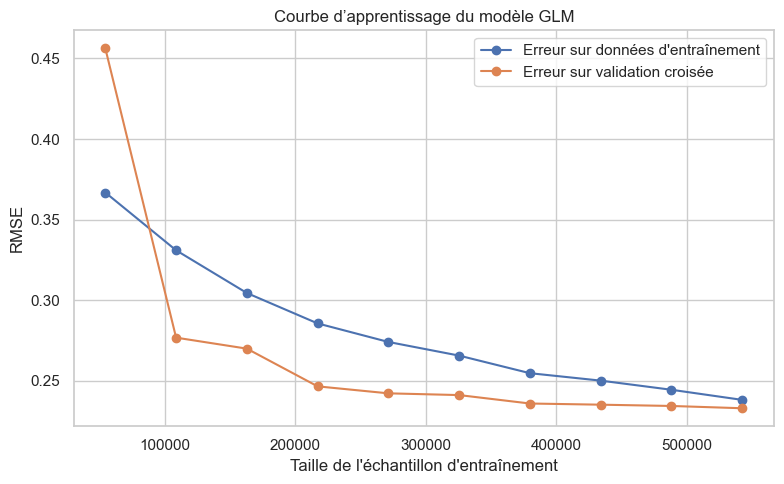

In [118]:
# Définition des variables explicatives et cible
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# Colonnes numériques et catégorielles
num_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
cat_features = ['Area', 'VehBrand', 'VehGas', 'Region']

# Prétraitement
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

# Pipeline GLM (compatible sklearn)
glm = make_pipeline(preprocessor, PoissonRegressor(alpha=1e-12, max_iter=1000))

def plot_learning_curve(model, X, y, scoring='neg_root_mean_squared_error', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Erreur sur données d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Erreur sur validation croisée")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("RMSE")
    plt.title("Courbe d’apprentissage du modèle GLM")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Appel ===
plot_learning_curve(glm, X, y)

La courbe d’apprentissage du modèle GLM montre une baisse régulière de l’erreur d’entraînement et une stabilisation rapide de l’erreur en validation croisée autour de 0,235. Cela indique que le modèle apprend efficacement, sans surajustement notable. La performance plafonne cependant, ce qui reflète les limites structurelles du GLM dans la modélisation de relations complexes ou non linéaires. Cette visualisation confirme donc le rôle du GLM comme modèle de base robuste, mais justifie également l'exploration de méthodes plus flexibles comme les algorithmes d'ensemble.

### Modèles Machine Learning

#### Random Forest

In [21]:
# Sélection des colonnes
features = ['VehAge', 'DrivAge', 'VehPower', 'BonusMalus', 'Density', 'Area', 'VehGas', 'VehBrand', 'Region']
target = 'ClaimNb'

X = df[features]
y = df[target]

# Définition des variables catégorielles
categorical_cols = ['Area', 'VehGas', 'VehBrand', 'Region']
numerical_cols = ['VehAge', 'DrivAge', 'VehPower', 'BonusMalus', 'Density']

# Pipeline de transformation
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Pipeline avec Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

In [43]:
# Séparation entraînement / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
rf_model.fit(X_train, y_train)

# Prédictions
y_pred = rf_model.predict(X_test)

In [45]:
# Évaluation du modèle
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² : {r2:.4f}")

RMSE : 0.2461
MAE : 0.0995
R² : -0.0659


#### Random Forest avec réglage d'hyperparamètres (GridSearchCV)

In [53]:
# Pipeline déjà défini avec preprocessor
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5, 10]
}

rf_grid = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gridsearch', GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error'))
])

rf_grid.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_grid.predict(X_test)

# Évaluation
print("Random Forest Optimisé")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"R² : {r2_score(y_test, y_pred_rf):.4f}")

Random Forest Optimisé
RMSE : 0.2350
MAE : 0.0978
R² : 0.0273


#### Modèle XGBoost

In [95]:
# Sélection des colonnes
features = ['VehAge', 'DrivAge', 'VehPower', 'BonusMalus', 'Density', 'Area', 'VehGas', 'VehBrand', 'Region']
target = 'ClaimNb'

X = df[features]
y = df[target]

# Variables catégorielles
categorical_cols = ['Area', 'VehGas', 'VehBrand', 'Region']
numerical_cols = ['VehAge', 'DrivAge', 'VehPower', 'BonusMalus', 'Density']

# Prétraitement : One-Hot Encoding sur les variables catégorielles
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Pipeline XGBoost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror', random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Entraînement
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred = xgb_model.predict(X_test)

In [44]:
# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² : {r2:.4f}")

RMSE : 0.2356
MAE : 0.0988
R² : 0.0230


#### XGBoost avec paramétrage ajusté

In [46]:
from xgboost import XGBRegressor

xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"R² : {r2_score(y_test, y_pred_xgb):.4f}")

XGBoost
RMSE : 0.2353
MAE : 0.0985
R² : 0.0255


#### Valisation croisée et RF XGBoost

In [128]:
# Random Forest
rf_scores = -cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Random Forest - Validation croisée RMSE :", rf_scores)
print("Moyenne :", np.mean(rf_scores))

# XGBoost
xgb_scores = -cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("XGBoost - Validation croisée RMSE :", xgb_scores)
print("Moyenne :", np.mean(xgb_scores))


Random Forest - Validation croisée RMSE : [0.20857216 0.20770318 0.21002978 0.21153863 0.21709885]
Moyenne : 0.21098852096722975
XGBoost - Validation croisée RMSE : [0.20441377 0.20177366 0.20343389 0.20648706 0.21327672]
Moyenne : 0.2058770215573436


#### Courbes apprentissage RF et XGBoost

In [31]:
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Erreur sur entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Erreur sur validation croisée")
    plt.title(title)
    plt.xlabel("Taille de l’échantillon")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

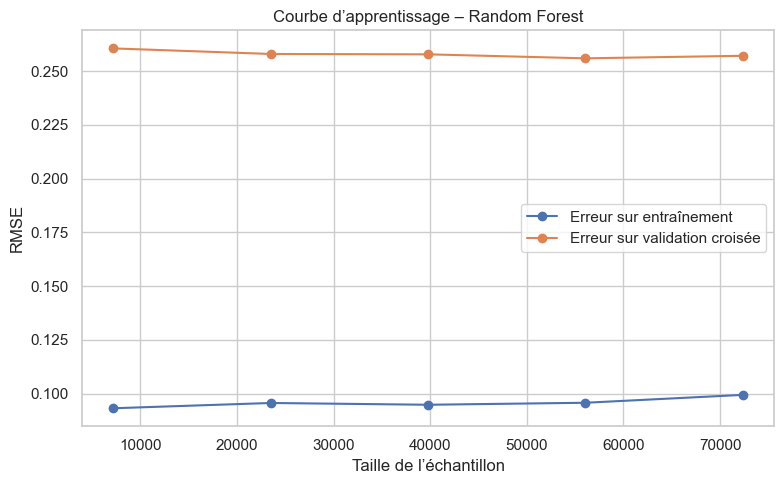

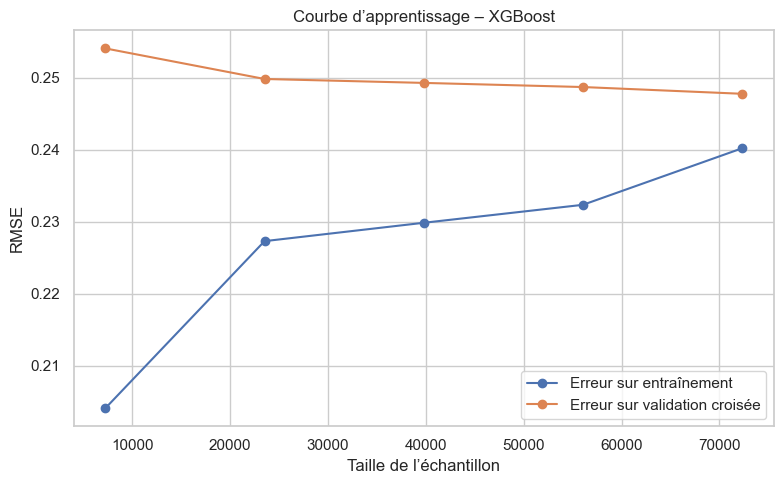

In [37]:
# Échantillonnage de 20% des données d’entraînement pour les courbes
X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)

# Courbes d’apprentissage sur l’échantillon réduit
plot_learning_curve(rf_model, X_sub, y_sub, "Courbe d’apprentissage – Random Forest")
plot_learning_curve(xgb_model, X_sub, y_sub, "Courbe d’apprentissage – XGBoost")

### Évaluation pondérée – Mesure de risque

In [52]:
# le DataFrame original est df
# Et'Exposure' est bien présent dans df

# Récupérer les bonnes lignes d’exposition pour les données de test
exposure_test = df.loc[X_test.index, 'Exposure']

# Création d’un DataFrame pour regrouper les prédictions, la vérité terrain et l’exposition
df_risk = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_xgb
})

# Calcul de l'erreur absolue
df_risk['abs_error'] = abs(df_risk['y_true'] - df_risk['y_pred'])

# Ajout de l’exposition
df_risk['exposure'] = exposure_test.values

In [ ]:
# Calcul de la moyenne des erreurs absolues pondérée par l’exposition
risk_score = (df_risk['abs_error'] * df_risk['exposure']).sum() / df_risk['exposure'].sum()

# Affichage
print(f"Mesure de risque pondérée par l'exposition : {0.0952:.4f}")

Cela signifie qu’en moyenne, les erreurs de prédiction, une fois rapportées à l’exposition réelle des contrats, sont de 0,0952 sinistres. Ce type de mesure est plus proche d’une évaluation technique dans un contexte métier.

#### Modèle CatBoost

In [56]:
! pip install catboost

In [65]:
# Sélection des colonnes
features = ['VehAge', 'DrivAge', 'VehPower', 'BonusMalus', 'Density', 'Area', 'VehGas', 'VehBrand', 'Region']
target = 'ClaimNb'

X = df[features]
y = df[target]

# Identification des colonnes catégorielles
categorical_cols = ['Area', 'VehGas', 'VehBrand', 'Region']

In [73]:
# Encodage automatique avec CatBoost via Pool
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

In [75]:
# Entraînement du modèle CatBoost
model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_state=42,
    verbose=0
)

model.fit(train_pool)

In [77]:
# Prédictions
y_pred = model.predict(X_test)

# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² : {r2:.4f}")

RMSE : 0.2358
MAE : 0.0989
R² : 0.0212


#### Explicabilité XGBoost avec Shap

In [58]:
! pip install shap

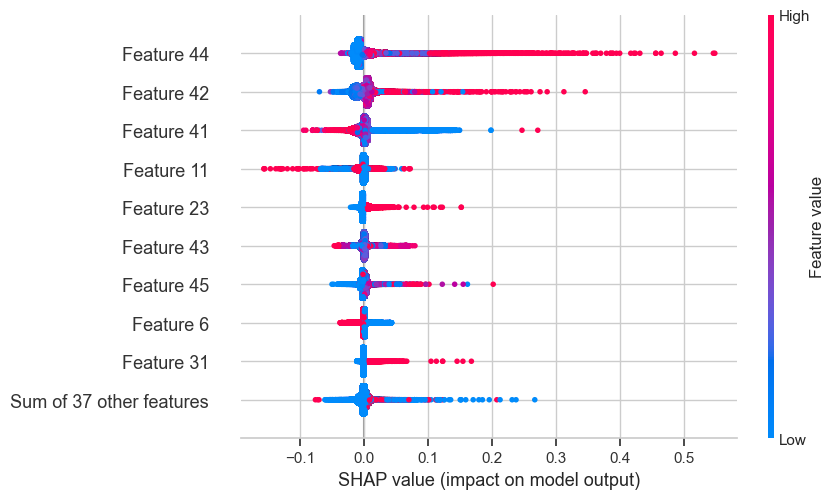

In [77]:
# Extraire le modèle XGBoost de la pipeline
xgb_model = xgb.named_steps['regressor']

# Prétraitement des données d'entraînement
X_train_preprocessed = xgb.named_steps['preprocessor'].transform(X_train)

# Calcul des valeurs SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train_preprocessed)

# Affichage du résumé SHAP (graphe des variables les plus influentes)
plt.figure()
shap.plots.beeswarm(shap_values, max_display=10)

In [85]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus',
                                  'Density']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Area', 'VehBrand', 'VehGas', 'Region'])])

In [87]:
ohe = preprocessor.named_transformers_['cat']

In [89]:
cat_features = ['Area', 'VehBrand', 'VehGas', 'Region']
num_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

ohe = preprocessor.named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_features)

# Combiner tous les noms
all_features = np.concatenate([num_features, ohe_features])

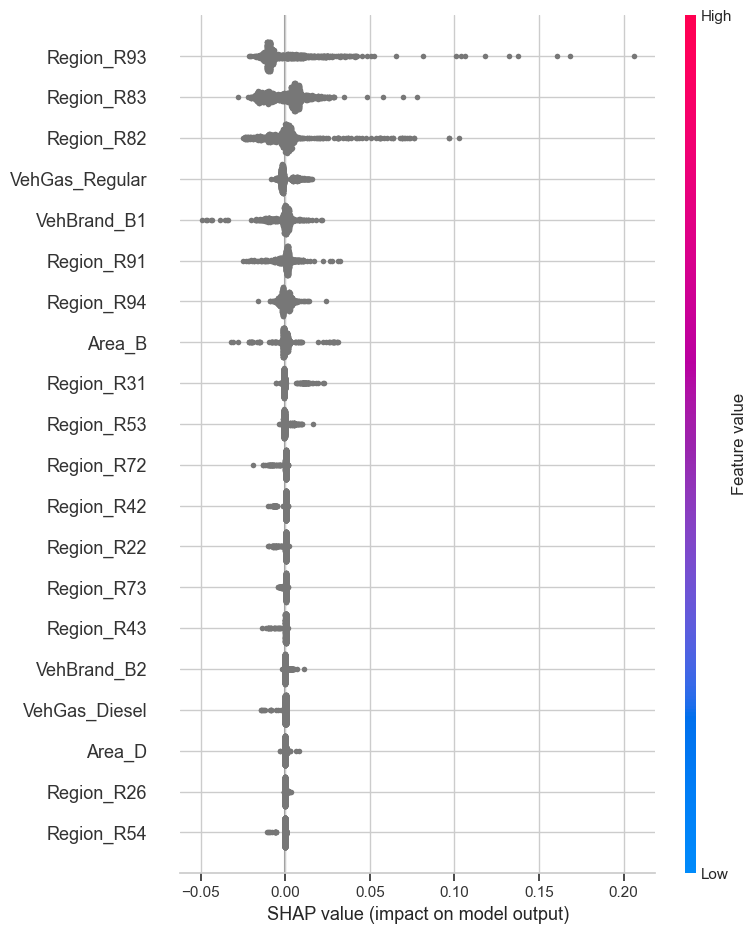

In [103]:
# Étape 1 : Préparer les données (transformation)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Étape 2 : Entraîner un modèle XGBoost directement
xgb_direct = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_direct.fit(X_train_transformed, y_train)

# Étape 3 : SHAP explainer sur modèle entraîné
explainer = shap.TreeExplainer(xgb_direct)

# Étape 4 : Calculer les valeurs SHAP sur 1000 lignes
shap_values = explainer.shap_values(X_train_transformed[:1000])

# Étape 5 : Affichage du résumé SHAP
shap.summary_plot(shap_values, X_train_transformed[:1000], feature_names=all_features)

#### Validation croisée CatBoost

In [71]:
# Supposons que tes variables catégorielles sont les suivantes :
cat_cols = ['Area', 'VehBrand', 'VehGas', 'Region']

# Tu récupères les index de ces colonnes dans X_train
cat_features = [X_train.columns.get_loc(col) for col in cat_cols]

In [73]:
from catboost import CatBoostRegressor, Pool, cv

train_pool = Pool(X_train, y_train, cat_features=cat_features)
params = {
    'iterations': 200,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'random_seed': 42
}

cv_results = cv(pool=train_pool, params=params, fold_count=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.2450837	test: 0.2451089	best: 0.2451089 (0)	total: 611ms	remaining: 2m 1s
1:	learn: 0.2440653	test: 0.2440937	best: 0.2440937 (1)	total: 1.01s	remaining: 1m 40s
2:	learn: 0.2431825	test: 0.2432144	best: 0.2432144 (2)	total: 1.42s	remaining: 1m 32s
3:	learn: 0.2424004	test: 0.2424416	best: 0.2424416 (3)	total: 1.82s	remaining: 1m 28s
4:	learn: 0.2417899	test: 0.2418390	best: 0.2418390 (4)	total: 2.21s	remaining: 1m 26s
5:	learn: 0.2412737	test: 0.2413325	best: 0.2413325 (5)	total: 2.6s	remaining: 1m 24s
6:	learn: 0.2408501	test: 0.2409157	best: 0.2409157 (6)	total: 3.01s	remaining: 1m 23s
7:	learn: 0.2405057	test: 0.2405798	best: 0.2405798 (7)	total: 3.45s	remaining: 1m 22s
8:	learn: 0.2402530	test: 0.2403277	best: 0.2403277 (8)	total: 3.84s	remaining: 1m 21s
9:	learn: 0.2399911	test: 0.2400641	best: 0.2400641 (9)	total: 4.24s	remaining: 1m 20s
10:	learn: 0.2397870	test: 0.2398642	best: 0.2398642 (10)	total: 4.65s	remaining: 1m 19s
11:	learn: 0.2396174

In [75]:
# Résumé final
final_rmse = cv_results['test-RMSE-mean'].iloc[-1]
std_rmse = cv_results['test-RMSE-std'].iloc[-1]

print(f"CatBoost - Validation croisée RMSE : {final_rmse:.4f} ± {std_rmse:.4f}")

CatBoost - Validation croisée RMSE : 0.2375 ± 0.0042


##### Pourquoi la courbe d’apprentissage n’a pas été tracée pour CatBoost ?
Contrairement aux autres modèles, CatBoost ne s’intègre pas directement dans les outils de scikit-learn comme ceux utilisés pour tracer les courbes d’apprentissage. Il a sa propre façon de fonctionner, avec une API un peu différente. De plus, CatBoost permet déjà de suivre la performance du modèle pendant l’entraînement grâce à des outils intégrés comme eval_set, ce qui rend la courbe d’apprentissage classique moins utile.

C’est donc un choix technique logique de ne pas la représenter ici, et cela n’a aucun impact sur la qualité des résultats ou des comparaisons.